In [1]:
import json
from pathlib import Path
from mt.helper import flatten
from datetime import datetime
from dateutil.parser import parse
from typing import Any
import networkx as nx
from torch_geometric.data import Data, Batch
import requests
import re
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import pickle
import concurrent.futures
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Repo processing

In [2]:
if (path:=Path("type_to_int.json")).exists():
    with open(path) as f:
        node_type_to_int = json.load(f)
else:
    response = requests.get("https://raw.githubusercontent.com/tree-sitter/tree-sitter-python/master/src/node-types.json")
    types = re.findall(r'"type": "(.+)"', response.text)
    node_type_to_int =  {"UNK": 0} | {t: i+1 for i, t in enumerate(list(set(types)))}
    with open("type_to_int.json", "w") as f:
        json.dump(node_type_to_int, f)

In [3]:
repo = Path("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision")
repo

PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision')

In [4]:
commit_data_dir = repo / "commit_data"
commit_paths = list(commit_data_dir.glob("*.json"))
commit_paths.sort(key = lambda path: int(path.name.split("_")[0]))
commit_paths = {path.name.split("_")[1].removesuffix(".json"): path for path in commit_paths}
# commit_paths

In [5]:
def issue_open_at(issue: dict[str, Any], date: datetime) -> bool:
    created_at = parse(issue["created_at"])
    closed_at = parse(issue["closed_at"]) if issue["closed_at"] else None
    return created_at.replace(tzinfo=None) < date and (
        not closed_at or closed_at.replace(tzinfo=None) > date
    )


def number_of_issues_open(issues: dict[str, Any], date: datetime) -> int:
    return sum([1 for issue in issues if issue_open_at(issue, date)])


def number_of_stars_at(stars: list[dict[str, Any]], date: datetime) -> int:
    count = 0
    for star in stars:
        if parse(star["starred_at"]).replace(tzinfo=None) <= date:
            count += 1
    return count

In [6]:
with open(repo / "stars.json") as f:
    stars = flatten([page["items"] for page in json.load(f)])

with open(repo / "commits.json") as f:
    commits = flatten([page["items"] for page in json.load(f)])

with open(repo / "issues.json") as f:
    issues = flatten([page["items"] for page in json.load(f)])

In [7]:
edge_type_to_int = {
    "child": 0,
    "occurance_of": 1,
    "may_next_use": 2,
}


def nx_to_pyg_graph(nx_graph: nx.DiGraph) -> tuple[Data, dict[int, str]]:
    node_mapping = {node: i for i, node in enumerate(nx_graph.nodes())}
    original_ids = {i: node for node, i in node_mapping.items()}

    x = [node_type_to_int.get(nx_graph.nodes[node]["type"], 0) for node in nx_graph.nodes]
    x = torch.tensor(x, dtype=torch.long).unsqueeze(1)  # Shape (num_nodes, 1)

    edge_list = []
    edge_attr = []
    for u, v, data in nx_graph.edges(data=True):
        edge_list.append([node_mapping[u], node_mapping[v]])
        edge_attr.append(edge_type_to_int[data["type"]])
    # edge_list = [[node_mapping[u], node_mapping[v]] for u, v in nx_graph.edges()]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.long).unsqueeze(1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr), original_ids


def file_features_to_graph(
    features: dict[str, str | bool | dict[str, int] | list[str]]
) -> tuple[Data, dict[int, str]]:
    with open(features["feature_file"]) as f:
        nx_graph = nx.node_link_graph(json.load(f)["ast"])
        return nx_to_pyg_graph(nx_graph)

In [8]:
pt_dir = repo / "pts"
pt_dir.mkdir(exist_ok=True)

In [9]:
# # Y = []
# # X = []
# # id_maps = []

# counter = 0
# for commit in commits:
#     if path:=commit_paths.get(commit["sha"]):
#         commit_date = parse(commit["commit"]["author"]["date"]).replace(tzinfo=None)

#         y_scale = number_of_stars_at(stars, commit_date)
#         y = number_of_issues_open(issues, commit_date)
#         y = y / (y_scale if y_scale else 1)
#         y = y * 1000

#         with open(path) as f:
#             raw_data = json.load(f)
        
#         maps, batch = [], []
#         for graph, id_map in [file_features_to_graph(file_features) for file_features in raw_data.values()]:
#             maps.append(id_map)
#             batch.append(graph)
        
#         batch = Batch.from_data_list(batch)
#         torch.save((commit["sha"], batch, y), pt_dir / f'batch_{counter}.pt')
#         with open(pt_dir / f"map_{counter}.pkl", "wb") as f:
#             pickle.dump(maps, f)
#         # X.append(batch)
#         # id_maps.append(maps)
#         counter += 1
#         print(commit["sha"], " Processed")

# Data loading

In [9]:
class GraphDataset(Dataset):
    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        self.files = list(root_dir.glob("*.pt"))
        self.num_samples = len(self.files)

        self.tgt_mean, self.tgt_std = self.compute_mean_std()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> tuple[str, Batch, torch.FloatTensor]:
        commit_sha, batch, target = torch.load(self.root_dir / f"batch_{idx}.pt")
        target_standardized = (target - self.tgt_mean) / self.tgt_std
        return commit_sha, batch, target_standardized
    
    def compute_mean_std(self) -> tuple[float, float]:
        tot_sum, tot_sum_sq, cnt = 0, 0, 0

        for file in self.files:
            _, _, target = torch.load(file)
            tot_sum += target
            tot_sum_sq += (target ** 2)
            cnt += 1
        
        mean = tot_sum / cnt
        var = (tot_sum_sq / cnt) - (mean ** 2)
        std = math.sqrt(var)

        return mean, std

    def inverse_standardize(self, target_standardized: float) -> float:
        return target_standardized * self.tgt_std + self.tgt_mean

In [10]:
# Instantiate the dataset
dataset = GraphDataset(root_dir=pt_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
for commit_sha, batched_data, target in dataloader:
    x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
    print(type(x), type(edge_index), type(batch), type(target))
    print(x.shape)
    print(edge_index.shape)
    print(commit_sha[0])
    break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([196380, 1])
torch.Size([2, 302739])
a129b6b86a75f2d1fc80055f2cd0fae63efc0d2d


# Model and training

In [11]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class NodeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NodeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, x):
        # Assuming x is of shape (num_nodes, 1) where each entry is the category index
        return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension
    

class EdgeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(EdgeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, edge_attr):
        # Assuming edge_attr is of shape (num_edges, 1) where each entry is the category index
        return self.embedding(edge_attr.squeeze())  # Embedding lookup and squeeze to drop extra dimension


class TransformerGATModel(nn.Module):
    def __init__(self, node_embedding_dim, edge_embedding_dim, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(node_embedding_dim, hidden_channels, heads=num_heads, concat=True, edge_dim=edge_embedding_dim)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True, edge_dim=edge_embedding_dim)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)
        
        attention_scores = self.attention_fc(x).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=0)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
node_embedding_dim = 64
edge_embedding_dim = 3
num_node_features = len(node_type_to_int)
num_edge_features = len(edge_type_to_int)

node_embedding_module = NodeFeatureEmbedding(num_embeddings=num_node_features, embedding_dim=node_embedding_dim)
edge_embedding_module = EdgeFeatureEmbedding(num_embeddings=num_edge_features, embedding_dim=edge_embedding_dim)
model = TransformerGATModel(node_embedding_dim=node_embedding_dim, edge_embedding_dim=edge_embedding_dim, hidden_channels=8, out_channels=1)
model.to(device)
edge_embedding_module.to(device)
node_embedding_module.to(device)

NodeFeatureEmbedding(
  (embedding): Embedding(216, 64)
)

In [ ]:
# optimizer = torch.optim.Adam(list(edge_embedding_module.parameters()) + list(node_embedding_module.parameters()) + list(model.parameters()), lr=0.01)
# criterion = nn.MSELoss()


# model.train()
# node_embedding_module.train()
# edge_embedding_module.train()
# for epoch in range(10):  # For example, 10 epochs
#     total_loss = 0
#     for commit_sha, graph_batch, target in dataloader:
#         # Transfer data to the device
#         x = graph_batch.x.to(device)
#         edge_index = graph_batch.edge_index.to(device)
#         edge_attr = graph_batch.edge_attr.to(device)
#         batch = graph_batch.batch.to(device)
#         target = target.to(device)
        
#         embedded_edge_attr = edge_embedding_module(edge_attr)
#         embedded_x = node_embedding_module(x)
        
#         optimizer.zero_grad()
        
#         # Embedding step
#         embedded_edge_attr = edge_embedding_module(edge_attr)
#         embedded_x = node_embedding_module(x)
        
#         # Model prediction
#         prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
#         loss = criterion(prediction, target)
        
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     print(f'Epoch {epoch+1}: Loss = {total_loss / len(dataloader)}')

In [24]:
weight_path = Path("best_weights_v2.pth")

In [25]:
best_loss = float('inf')  # Initialize best_loss to infinity
best_model_state = None   # To store the state of the best model

optimizer = torch.optim.Adam(
    list(edge_embedding_module.parameters())
    + list(node_embedding_module.parameters())
    + list(model.parameters()),
    lr=0.01,
)
criterion = nn.MSELoss()

for train_loop in range(5):
    print(f"{datetime.now()}: Training loop {train_loop + 1}")
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.1

    if weight_path.exists():
        weights = torch.load(weight_path)
        node_emb_weights, edge_emb_weights, model_weights = (
            weights["node_embedding_module_state_dict"],
            weights["edge_embedding_module_state_dict"],
            weights["model_state_dict"],
        )
        node_embedding_module.load_state_dict(node_emb_weights)
        edge_embedding_module.load_state_dict(edge_emb_weights)
        model.load_state_dict(model_weights)

    model.train()
    node_embedding_module.train()
    edge_embedding_module.train()

    best_loss = float("inf")  # Initialize best_loss to infinity
    best_model_state = None  # To store the state of the best model

    for epoch in range(20):  # For example, 10 epochs
        total_loss = 0
        for commit_sha, graph_batch, target in dataloader:
            # Transfer data to the device
            x = graph_batch.x.to(device)
            edge_index = graph_batch.edge_index.to(device)
            edge_attr = graph_batch.edge_attr.to(device)
            batch = graph_batch.batch.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            
            # Embedding step
            embedded_edge_attr = edge_embedding_module(edge_attr)
            embedded_x = node_embedding_module(x)
            
            # Model prediction
            prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
            loss = criterion(prediction, target)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        epoch_loss = total_loss / len(dataloader)
        print(f"{datetime.now()}: Epoch {epoch+1}: Loss = {epoch_loss}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            # Save the model state
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "node_embedding_module_state_dict": node_embedding_module.state_dict(),
                "edge_embedding_module_state_dict": edge_embedding_module.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_loss,
            }
            # Example saving to file, adjust the path as necessary
            torch.save(best_model_state, weight_path)

    print(f"{datetime.now()}: Best Loss: {best_loss}")

2024-05-12 07:47:52.851273: Training loop 1
2024-05-12 07:49:38.757865: Epoch 1: Loss = 0.8244268807067595
2024-05-12 07:51:25.404653: Epoch 2: Loss = 0.5304120342784394
2024-05-12 07:53:11.225408: Epoch 3: Loss = 0.5070176851346306
2024-05-12 07:54:56.571681: Epoch 4: Loss = 0.488525600080777
2024-05-12 07:56:42.547457: Epoch 5: Loss = 0.49476610177698865
2024-05-12 07:58:28.200550: Epoch 6: Loss = 0.4835467514027695
2024-05-12 08:00:14.391527: Epoch 7: Loss = 0.4892967035244123
2024-05-12 08:02:00.127974: Epoch 8: Loss = 0.5008037884558907
2024-05-12 08:03:46.091070: Epoch 9: Loss = 0.49213357554458215
2024-05-12 08:05:32.830084: Epoch 10: Loss = 0.4621575241361147
2024-05-12 08:07:18.946030: Epoch 11: Loss = 0.49641052918055734
2024-05-12 08:09:05.486248: Epoch 12: Loss = 0.42878078278014453
2024-05-12 08:10:51.982519: Epoch 13: Loss = 0.4973228196633799
2024-05-12 08:12:40.636920: Epoch 14: Loss = 0.49033223983051194
2024-05-12 08:14:29.743040: Epoch 15: Loss = 0.4669281518346947
2

In [26]:
print(f'Best Loss: {best_loss}')

Best Loss: 0.3013705655923751


In [17]:
weights = torch.load(weight_path)
node_emb_weights, edge_emb_weights, model_weights = (
    weights["node_embedding_module_state_dict"],
    weights["edge_embedding_module_state_dict"],
    weights["model_state_dict"],
)
node_embedding_module.load_state_dict(node_emb_weights)
edge_embedding_module.load_state_dict(edge_emb_weights)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [18]:
model.to(device)
node_embedding_module.to(device)
edge_embedding_module.to(device)

model.eval()
node_embedding_module.eval()
edge_embedding_module.eval()

EdgeFeatureEmbedding(
  (embedding): Embedding(3, 3)
)

# Testing the model

In [19]:
targets = []
predictions = []

for commit_sha, graph_batch, target in dataloader:
    # Transfer data to the device
    x = graph_batch.x.to(device)
    edge_index = graph_batch.edge_index.to(device)
    edge_attr = graph_batch.edge_attr.to(device)
    batch = graph_batch.batch.to(device)
    target = target.to(device)
    
    # Embedding step
    embedded_edge_attr = edge_embedding_module(edge_attr)
    embedded_x = node_embedding_module(x)
    
    # Model prediction
    prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
    targets.append(target.detach().cpu())
    predictions.append(prediction.detach().cpu())
    # loss = criterion(prediction, target)
    
    # loss.backward()
    # optimizer.step()
    
    # total_loss += loss.item()

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

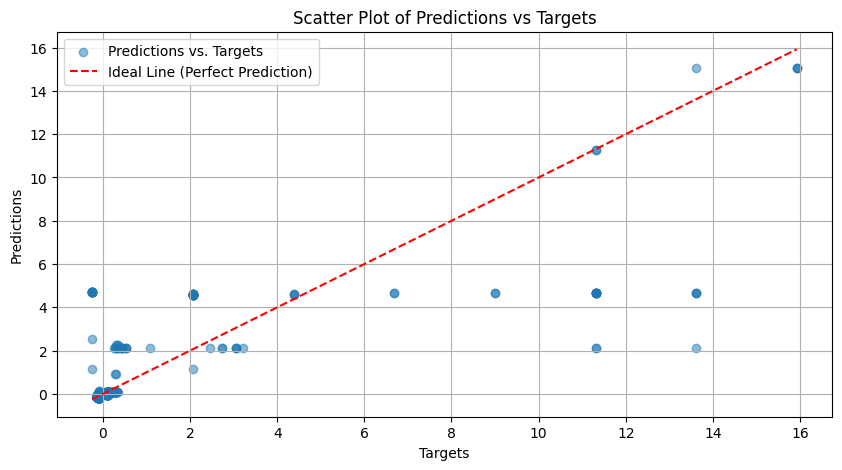

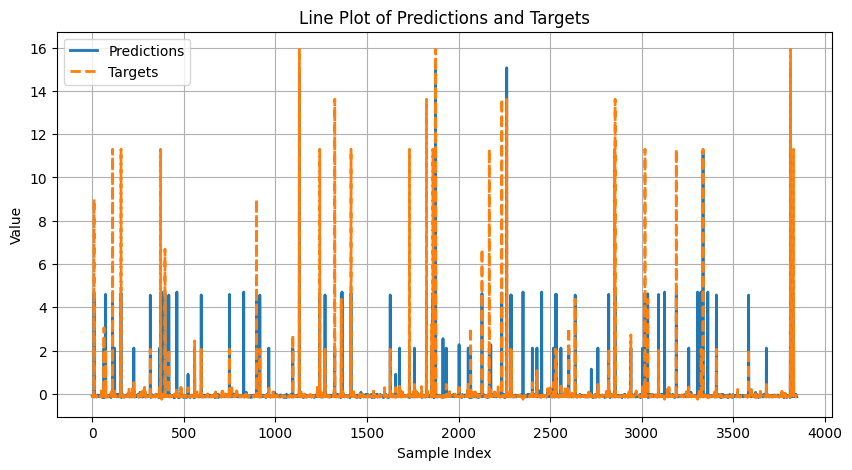

In [27]:
# Scatter plot of predictions vs. targets
plt.figure(figsize=(10, 5))
plt.scatter(targets, predictions, alpha=0.5, label='Predictions vs. Targets')
plt.title('Scatter Plot of Predictions vs Targets')

# Ideal line (x = y line)
ideal_line_range = np.linspace(min(targets.min(), predictions.min()), 
                               max(targets.max(), predictions.max()), 
                               num=100)
plt.plot(ideal_line_range, ideal_line_range, 'r--', label='Ideal Line (Perfect Prediction)')

plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Line plot of predictions and targets
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', linewidth=2)
plt.plot(targets, label='Targets', linewidth=2, linestyle='--')
plt.title('Line Plot of Predictions and Targets')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
targets, predictions

(array([-0.09886418, -0.12905103, -0.1168808 , ..., -0.10016641,
        -0.0961696 , -0.11603551], dtype=float32),
 array([-0.09213758, -0.12178922, -0.10975432, ..., -0.08936191,
        -0.09617949, -0.12208486], dtype=float32))

# Explainability

In [ ]:
from torch_geometric.explain import CaptumExplainer, Explainer, AttentionExplainer, DummyExplainer, GNNExplainer, GraphMaskExplainer


gnn_explainer = GNNExplainer().to(device)
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer,
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    node_mask_type='object',
    edge_mask_type='object',
    # threshold_config=dict(
    #     threshold_type='topk',
    #     value=200,
    # ),
)

In [ ]:
dataset[20]

('85c586c673ce09513562adb80c1513c2796e3bc9',
 DataBatch(x=[947542, 1], edge_index=[2, 1472098], edge_attr=[1472098, 1], batch=[947542], ptr=[355]),
 -0.09843273986741516)

In [ ]:
commit_sha, batched_data, target = dataset[20]

x = batched_data.x.to(device)
edge_index = batched_data.edge_index.to(device)
edge_attr = batched_data.edge_attr.to(device)
batch = batched_data.batch.to(device)

embedded_batched_data = node_embedding_module(x).detach()
embedded_edge_attr_data = edge_embedding_module(edge_attr).detach()
explanation = explainer(embedded_batched_data, edge_index, edge_attr=embedded_edge_attr_data, batch=batch)
explanation

Explanation(node_mask=[947542, 1], edge_mask=[1472098], prediction=[1], target=[1], x=[947542, 64], edge_index=[2, 1472098], edge_attr=[1472098, 3], batch=[947542])

In [ ]:
# Graph creation
# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

In [ ]:
# Assuming edge_index and edge_importance are already defined
# Identify the top 15 edges based on importance
top_edge_indices = np.argsort(-edge_importance)[:15]
top_edges = [(edge_index_np[0][i], edge_index_np[1][i]) for i in top_edge_indices]

# Collect nodes from these top edges
nodes_from_top_edges = set()
for u, v in top_edges:
    nodes_from_top_edges.update([u, v])

# Ensure nodes from top edges are included, along with top nodes based on their importance
top_nodes_indices = np.argsort(-node_importance, axis=0)[:15].reshape(-1)
nodes_from_top_nodes = set(np.array(G.nodes)[top_nodes_indices])

# Combine nodes from top nodes and top edges
all_top_nodes = nodes_from_top_edges.union(nodes_from_top_nodes)

# Create the subgraph based on these nodes
H = G.subgraph(all_top_nodes)

In [ ]:
# Print top node importance values to verify correct nodes are being selected
top_nodes_indices = np.argsort(-node_importance, axis=0)[:5].reshape(-1)
print("Top node indices:", top_nodes_indices)
print("Node importance scores for these indices:", node_importance[top_nodes_indices])

# Convert indices to actual nodes (if G.nodes() returns nodes in a consistent order with node_importance)
nodes_from_top_nodes = {list(G.nodes())[i] for i in top_nodes_indices}
print("Nodes selected based on top indices:", nodes_from_top_nodes)

# Verify these are the correct nodes by checking their importance scores
print("Importance scores of selected nodes:")
for node in nodes_from_top_nodes:
    print(f"Node {node}: {node_importance[list(G.nodes()).index(node)]}")

# Collect nodes from top edges
nodes_from_top_edges = {u for u, v in top_edges} | {v for u, v in top_edges}

# Combine nodes from top nodes and top edges
all_top_nodes = nodes_from_top_edges.union(nodes_from_top_nodes)

# Create the subgraph based on these nodes
H = G.subgraph(all_top_nodes)
print("Nodes in subgraph H:", H.nodes())
print("Edges in subgraph H:", H.edges())

Top node indices: [565485 565776 565131 565605 565412]
Node importance scores for these indices: [[0.76257956]
 [0.75712305]
 [0.7568133 ]
 [0.7549527 ]
 [0.74817216]]
Nodes selected based on top indices: {565698, 565381, 565102, 565300, 565502}
Importance scores of selected nodes:
Node 565698: [0.75712305]
Node 565381: [0.76257956]
Node 565102: [0.7568133]
Node 565300: [0.74817216]
Node 565502: [0.7549527]
Nodes in subgraph H: [565381, 565650, 565395, 565906, 565651, 565396, 565543, 565544, 565300, 565944, 565946, 565818, 565819, 565564, 565181, 565698, 565197, 565198, 565199, 565335, 565336, 565337, 565472, 565473, 565353, 565354, 565102, 565231, 565232, 565361, 565502]
Edges in subgraph H: [(565650, 565651), (565395, 565396), (565906, 565181), (565906, 565336), (565543, 565544), (565543, 565564), (565944, 565946), (565818, 565819), (565181, 565198), (565181, 565336), (565197, 565198), (565197, 565199), (565198, 565336), (565335, 565336), (565335, 565337), (565472, 565473), (565353, 

In [ ]:
node_importance[top_nodes_indices]

array([[0.76257956],
       [0.75712305],
       [0.7568133 ],
       [0.7549527 ],
       [0.74817216]], dtype=float32)

In [ ]:
edge_importance[top_edge_indices]

array([0.68554115, 0.68510586, 0.68263984, 0.6667244 , 0.6643122 ,
       0.6636584 , 0.66344315, 0.66290647, 0.6610761 , 0.6602299 ,
       0.65966076, 0.65961254, 0.659231  , 0.6591313 , 0.6590343 ],
      dtype=float32)

In [ ]:
# Example to check the presence of directed edges
for u, v in H.edges():
    direct_match = np.where((edge_index_np[0] == u) & (edge_index_np[1] == v))[0]
    reverse_match = np.where((edge_index_np[0] == v) & (edge_index_np[1] == u))[0]

    if direct_match.size > 0:
        print(f"Direct edge ({u}, {v}) found at index {direct_match[0]}")
    elif reverse_match.size > 0:
        print(f"Reverse edge ({v}, {u}) found at index {reverse_match[0]}")
    else:
        print(f"No matching edge found for ({u}, {v}) or ({v}, {u})")

Direct edge (565650, 565651) found at index 885250
Direct edge (565395, 565396) found at index 884893
Direct edge (565906, 565181) found at index 885633
Reverse edge (565336, 565906) found at index 884814
Direct edge (565543, 565544) found at index 885114
Direct edge (565543, 565564) found at index 885116
Direct edge (565944, 565946) found at index 885674
Direct edge (565818, 565819) found at index 885498
Direct edge (565181, 565198) found at index 884571
Direct edge (565181, 565336) found at index 884572
Direct edge (565197, 565198) found at index 884597
Direct edge (565197, 565199) found at index 884598
Direct edge (565198, 565336) found at index 884600
Direct edge (565335, 565336) found at index 884811
Direct edge (565335, 565337) found at index 884812
Direct edge (565472, 565473) found at index 885013
Direct edge (565353, 565354) found at index 884837
Direct edge (565353, 565361) found at index 884842
Direct edge (565231, 565232) found at index 884642


In [ ]:
# Check if all nodes of the included edges are part of the subgraph
for u, v in top_edges:
    if not H.has_node(u) or not H.has_node(v):
        print(f"Missing node for edge ({u}, {v}) in subgraph H.")

for n in top_nodes_indices:
    if not H.has_node(n):
        print(f"???")

???
???
???
???
???


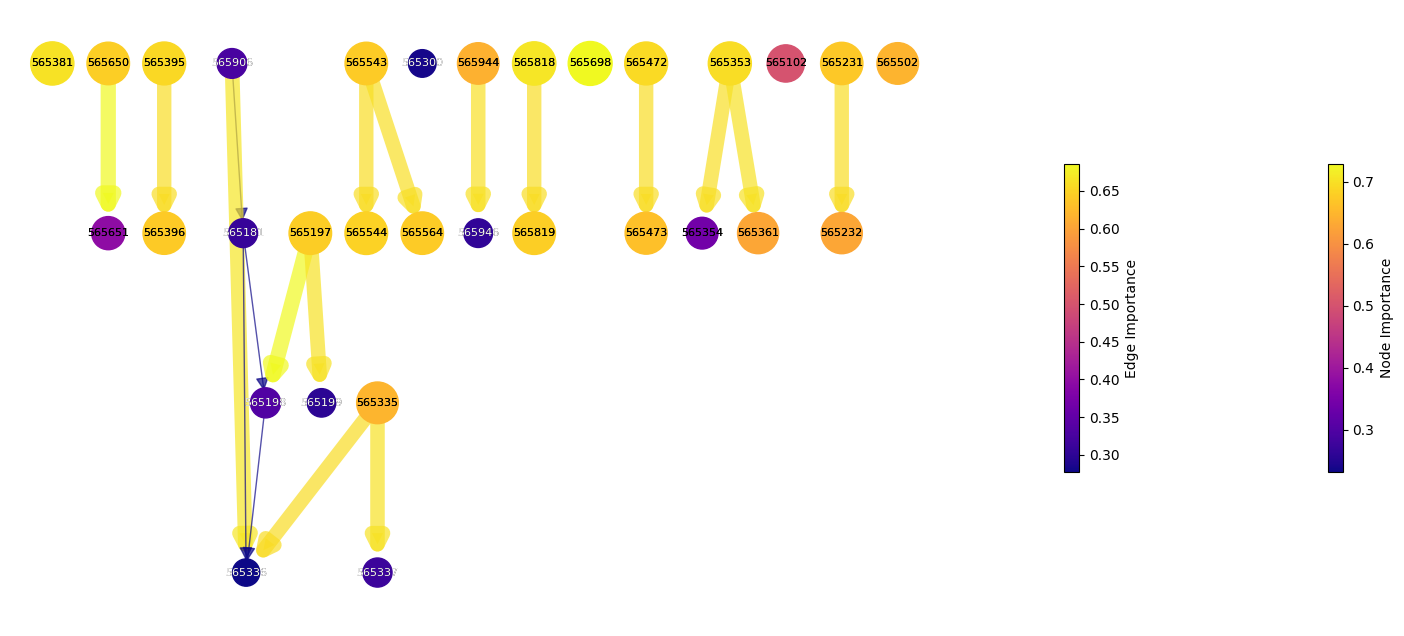

In [ ]:
# Update node and edge importance arrays for visualization
node_importance_H = np.array([node_importance[node] for node in H.nodes])
edge_importance_H = np.array([edge_importance[np.where(((edge_index_np[0] == u) & (edge_index_np[1] == v)) | ((edge_index_np[0] == v) & (edge_index_np[1] == u)))[0][0]] for u, v in H.edges])

# Normalize importance
norm_node = mcolors.Normalize(vmin=node_importance_H.min(), vmax=node_importance_H.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_H.min(), vmax=edge_importance_H.max())

# Set up color maps
cmap = plt.cm.plasma
cmap_edge = plt.cm.plasma

# Define colors and widths based on importance
node_colors = [cmap(norm_node(value)) for value in node_importance_H]
edge_colors = [cmap_edge(norm_edge(value)) for value in edge_importance_H]
edge_widths = [1 + 10 * norm_edge(value) for value in edge_importance_H]

# Layout and drawing
pos = nx.nx_agraph.graphviz_layout(H, prog='dot')
# pos = nx.spring_layout(H)
fig, ax = plt.subplots(figsize=(20, 8))
nx.draw_networkx_nodes(H, pos, node_size=100 + 900 * (node_importance_H / node_importance_H.max()), node_color=node_colors, ax=ax)
nx.draw_networkx_edges(H, pos, edgelist=H.edges(), width=edge_widths, edge_color=edge_colors, alpha=0.7, arrowstyle='-|>', arrowsize=20, arrows=True, ax=ax)
nx.draw_networkx_labels(H, pos, font_size=8, ax=ax)

# Node labels with contrasting colors
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(cmap(norm_node(node_importance[node]))) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Colorbars for node and edge importance
sm_node = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm_node.set_array([])
cbar_node = plt.colorbar(sm_node, ax=ax, orientation='vertical', shrink=0.5, label='Node Importance')

sm_edge = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
sm_edge.set_array([])
cbar_edge = plt.colorbar(sm_edge, ax=ax, orientation='vertical', shrink=0.5, label='Edge Importance', pad=0.1)

plt.show()

KeyboardInterrupt: 

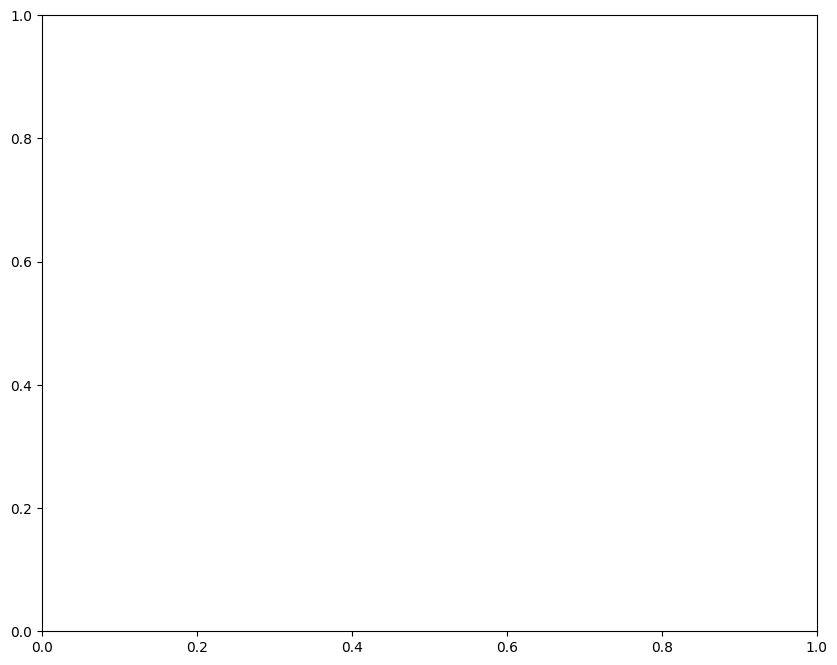

In [ ]:
# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

fig, ax = plt.subplots(figsize=(10, 8))

# Use PyGraphviz to find the tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# Node sizes and colors based on importance
node_sizes = 100 + 900 * node_importance_normalized
node_colors = [cmap(norm_node(value)) for value in node_importance_normalized]

# Apply a power transformation to increase variation in edge widths
edge_widths = 1 + np.power(edge_importance_normalized * 2, 4)  # Adjust the exponent as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)

# Draw edges with colors and widths based on their importance
edges = edge_index_np.T
edge_colors = [cmap(norm_edge(edge_importance_normalized[i])) for i in range(len(edges))]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, ax=ax)

# Draw node labels with contrasting colors for readability
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(node_colors[node]) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Add colorbar as a legend for node and edge importance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Importance')

plt.show()

In [ ]:
import pygraphviz as pgv
from IPython.display import Image

# Create a PyGraphviz graph from the NetworkX graph
A = nx.nx_agraph.to_agraph(G)

# Apply styles to nodes and edges based on importance scores
for i, (node, imp) in enumerate(zip(G.nodes(), node_importance_normalized)):
    color = plt.cm.viridis(norm_node(imp))
    hex_color = mcolors.rgb2hex(color)
    A.get_node(node).attr['style'] = 'filled'
    A.get_node(node).attr['fillcolor'] = hex_color
    A.get_node(node).attr['width'] = str(0.1 + 0.9 * imp)  # adjust the size

for i, ((src, dst), imp) in enumerate(zip(G.edges(), edge_importance_normalized)):
    color = plt.cm.viridis(norm_edge(imp))
    hex_color = mcolors.rgb2hex(color)
    A.get_edge(src, dst).attr['color'] = hex_color
    A.get_edge(src, dst).attr['penwidth'] = str(1 + np.power(imp * 2, 4))  # adjust the width based on importance

# Set Graphviz layout options (e.g., 'dot', 'neato', 'fdp')
A.layout(prog='dot')

# Draw and display the graph (output as PNG for viewing in Jupyter)
A.draw('graph.png')
Image('graph.png')

KeyboardInterrupt: 

# Visualization on original file

In [ ]:
from pyvis.network import Network
import networkx as nx

# Initialize Pyvis network
net = Network(notebook=False, height="750px", width="100%")

# Add nodes with size and color based on importance
for node in G.nodes():
    node_imp = node_importance_normalized[node]
    node_color = plt.cm.viridis(norm_node(node_imp))
    hex_color = mcolors.rgb2hex(node_color)
    net.add_node(node, title=f'Node: {node}', size=10 + 90 * node_imp, color=hex_color)

# Add edges with width and color based on importance
for src, dst in G.edges():
    edge_idx = G.edges[src, dst]['index']
    edge_imp = edge_importance_normalized[edge_idx]
    edge_color = plt.cm.viridis(norm_edge(edge_imp))
    hex_color = mcolors.rgb2hex(edge_color)
    width = 1 + np.power(edge_imp * 2, 4)  # Apply a power transformation to increase variation
    net.add_edge(src, dst, width=width, color=hex_color, title=f'Importance: {edge_imp:.2f}')

# Set the physics layout for the network
net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "centralGravity": 0.3,
      "springLength": 95
    },
    "minVelocity": 0.75
  }
}
""")

# Generate the network in an HTML file
net.show("graph.html")

In [ ]:
path = commit_paths["1fda0e850a2ff5dca7f10a2e12286c87645d6760"]

node_to_file = {}


with open(path) as f:
    raw_data = json.load(f)

for fp, features in raw_data.items():
    with open(features["feature_file"]) as f:
        graph = nx.node_link_graph(json.load(f)["ast"])
    
    for node in graph.nodes():
        node_to_file[node] = (fp, graph)

In [ ]:
fp, graph = node_to_file["018f29763d047805904763c2534d568a"]
graph.nodes["018f29763d047805904763c2534d568a"]

{'type': 'import_statement',
 'start_line': 1,
 'end_line': 1,
 'start_col': 0,
 'end_col': 13}

In [ ]:
commit_sha, batch, y = dataset[0]

with open(pt_dir / "map_0.pkl", "rb") as f:
    id_map = pickle.load(f)

commit_sha, len(id_map), batch.batch

('1fda0e850a2ff5dca7f10a2e12286c87645d6760',
 352,
 tensor([  0,   0,   0,  ..., 351, 351, 351]))

In [ ]:
graph_id = batch.batch[3531].item()
local_node_index = (3531 - batch.ptr[graph_id]).item()
original_id = id_map[graph_id][local_node_index]
original_id

'018f29763d047805904763c2534d568a'

In [ ]:
dataset[0][1].num_nodes

533455

In [ ]:
in_node = 24980
batch = dataset[0][1]
graph_id = batch.batch[in_node].item()
node_offset = (batch.batch == graph_id).nonzero(as_tuple=True)[0][0].item()
local_node_index = in_node - node_offset

graph_id, node_offset, local_node_index

(11, 19966, 5014)

In [ ]:
def batch_to_original_id(
    batch: Batch,
    id_maps: list[dict[int, str]],
    batch_node_id: int,
) -> str:
    # Determine which graph this node belongs to using the 'batch' attribute
    graph_id = batch.batch[batch_node_id].item()

    # Retrieve the offset for nodes of this graph in the batch
    node_offset = (batch.batch == graph_id).nonzero(as_tuple=True)[0][0].item()

    # Calculate the local index of the node in its original graph
    local_node_index = batch_node_id - node_offset

    # Use the local index to get the original ID from the ID map
    original_id = id_maps[graph_id][local_node_index]

    return original_id


with open(pt_dir / "map_0.pkl", "rb") as f:
    id_map = pickle.load(f)


batch_to_original_id(dataset[0][1], id_map, 24980)

'018f2978d65e77d3a3aed1ba76c20481'